## 2) Time Series Decomposition

### Overview
This notebook explores the decomposition of time series data into its main components: trend, seasonality, cycles, and residuals. This process provides insights into the structure of time series data and aids in building predictive models.

### Table of Contents
#### 2.1) Components of a Time Series
#### 2.2) Trend
#### 2.3) Seasonality
  - 2.3.1) Seasonal Indicators
  - 2.3.2) Fourier Features
#### 2.4) Cycles
#### 2.5) Residual
#### 2.6) Time Series Decomposition using Statsmodels
#### 2.7) Time Series Decomposition using Prophet

---

### 2.1) Components of a Time Series

A **time series (TS)** is a set of observations recorded over time at regular intervals. Time plays a critical role as a feature, often affecting the observed target variable. For example:
- Seasons, weekdays, and times of day can influence the sales of a shop.
- Past values can influence future values, a relationship referred to as lag effects.

A time series can generally be decomposed into the following components:

1. **Trend**: Represents long-term, persistent movements in the data. For instance, the steady increase in a company's stock price over several years.
2. **Seasonality**: Regular patterns that repeat over fixed intervals, such as weekly or yearly cycles.
3. **Cycles**: Irregular fluctuations influenced by lag effects and external factors.
4. **Residuals**: The random noise left after accounting for the above components.

Additionally, events and holidays (other than weekends, which are typically captured in weekly seasonality) can impact the target values of a time series.

---

### 2.2) Trend

The **trend** is the slowest-moving component of a time series. It captures long-term changes in the series' average value.

#### Example:
A linear or polynomial increase in a stock price over several years can represent the trend component.

#### Finding the Trend:
- Use time as a feature and fit a line or curve using linear or polynomial regression.
- Tools such as the `statsmodels` package can help estimate the trend component.

---

### 2.3) Seasonality

The **seasonality** component represents regular oscillations with fixed frequencies. Common examples include:
- Weekly seasonality (e.g., higher sales on weekends).
- Yearly seasonality (e.g., sales spikes during December).

#### 2.3.1) Seasonal Indicators
Seasonal indicators are categorical variables that identify specific times, such as months or days of the week, helping to model seasonal patterns effectively.

#### 2.3.2) Fourier Features
Fourier transformations provide a mathematical way to capture periodic patterns in the data. These features are especially useful when seasonality cannot be directly captured by categorical indicators.

---

### 2.4) Cycles

**Cycles** refer to irregular, non-seasonal fluctuations in a time series. These patterns often stem from lagged effects and dependencies, where past values influence the present and future.

#### Characteristics:
- Cycles vary in frequency and amplitude.
- They are harder to identify compared to regular seasonal patterns.

---

### 2.5) Residuals

The **residual** is what remains after removing the trend, seasonality, and cyclic components from a time series. Residuals represent:
- Random noise.
- Variations driven by external or unmeasured factors.

Understanding residuals helps determine whether additional factors should be incorporated into the model.

---

### 2.6) Time Series Decomposition using Statsmodels

The `statsmodels` library provides tools for decomposing time series into its components. Here's an example:

```python
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming 'time_series_data' is a pandas Series with a DateTime index
result = seasonal_decompose(time_series_data, model='additive', period=12)

# Plot the decomposed components
result.plot()
plt.show()
```

---

### 2.7) Time Series Decomposition using Prophet

Prophet, developed by Facebook, is another powerful tool for time series analysis. It can handle trend, seasonality, and holiday effects effectively.


In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
tunnel = pd.read_csv("tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [2]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


**Excercise**: 
- Play with order and constant and drop options and see what happens.
- Can you make a linear, or quadratic trend without using statsmodels? Of-course.! Do it please.

**Fit a curve for trend**
* Now we can fit a curve with linear(or polynomial) regression to our dataset

In [3]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

* The good point about statsmodel is that we can easily extend the features to future and predict it with our ML model.

In [4]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

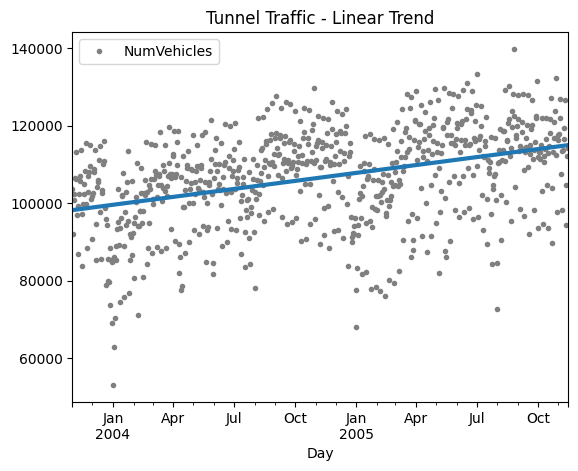

In [5]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

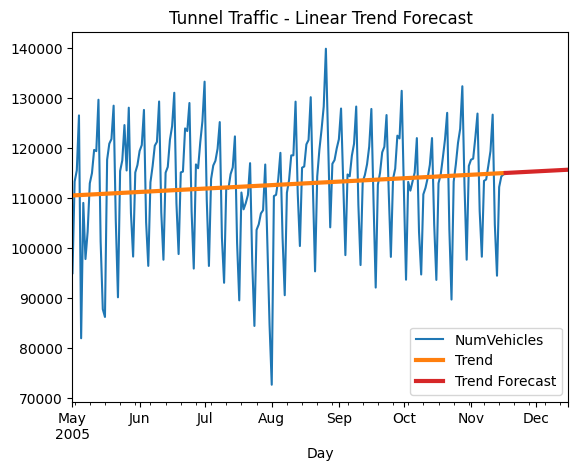

In [6]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast")
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

* Are you happy with above trend? Then go to the next part. Do you think it is better to play with some options (such as fitting with a quadratic trend)? Be my guest, but at the end, do not forget the next part.

### 2.3) Seasonality

* Seasonality includes any repeating pattern with any constant frequency in a time-series. 

* Some examples are: - the effect of different months on the sale clothes. - Weekday effect on the price of oil. More? Think about it.

* We deal with long-period seasonality in different way than short-period ones. While for tha latter, we use seasonal indicator, for the former, it is more practical to use Fourier features. If the time-serie is for example daily-based, then a weekly seasonality would fits into short term and yearly seasonality fits into long term.

#### 2.3.1) Seasonal indicators

* In this method, we treat the components of seasonal variable (e.g. in weekly seasonality it will be the weekday) as a categorical feature, and then apply the one-hot-encoding and finally fit the time serie with linear regression (or another ML method).

* Linear regression works best if you drop one of the indicators, e.g. Monday, then it considers it as an intercept.

**Excercise** 
* Use the previous TS (tunnel) and explore the weekday effect in it.
* First, subtract a linear trend from it. Then, make categorical feature for weekdays, do the one-hot encoding and remove one of them. Finally apply the linear regression.
* Now, use the mean of the effect of different days: subtract the trend, make another feature named day of the week or something, groupby and average over that feature.
* Compare the results

#### 2.3.2) Fourier features

* For long seasons, it is impractical to use indicators over many observations, instead we use Fourier transformation with fourier components. 

**Computing Furier** 

* We can define the Fourier components by using the following function:

In [7]:
import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
#
# fourier_features(y, freq=365.25, order=4)

* However, statsmodels package do all these things (trend, indicators, and Fourier components) for us:

In [8]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

In [9]:
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Day,,,,,,,,,,,,,,,,,,,,,
2003-11-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.867456,0.497513,...,-0.017213,0.999852,-0.875892,0.482508,-0.854322,-0.519744,0.025818,-0.999667,0.880012,-0.474951
2003-11-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.858764,0.512371,...,0.085965,0.996298,-0.811539,0.584298,-0.917584,-0.397543,-0.128748,-0.991677,0.785650,-0.618671
2003-11-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.849817,0.527078,...,0.188227,0.982126,-0.735417,0.677615,-0.963471,-0.267814,-0.280231,-0.959933,0.668064,-0.744104
2003-11-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.840618,0.541628,...,0.288482,0.957485,-0.648630,0.761104,-0.991114,-0.133015,-0.425000,-0.905193,0.530730,-0.847541
2003-11-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.831171,0.556017,...,0.385663,0.922640,-0.552435,0.833556,-0.999991,0.004304,-0.559589,-0.828770,0.377708,-0.925925


Now, It is time to fit it with a regression model

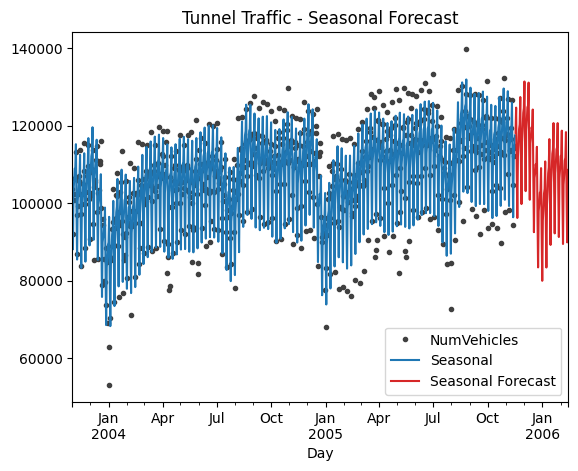

In [10]:
y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

### 2.4) Cycles

**Serial Dependency** : 
* So far, we see the TS properties that deponds on the time index. However, there are properties that instead of depending on the current time, they depond on what happened in the past. These properties may not be apparent from a plot over time but they appear in plots against past values.

**Cycles** :
* One of special cases of serial dependencies is cycle. It is up and downs in the TS, that do not depend on the time, but on what happened in the past. Hence, in contrast to the seasonality they don't have a reqular pattern with some fixed frequencies.

**Lagged feature**:
* To investigate the cycles it is needed to add the information about the past to the dataset. It can be done by using the lag features. Lagging a time series means to shift its values forward one or more time steps.

* The lag effect csan be captured by the **shift** method.

In [11]:

import pandas as pd

# Federal Reserve dataset: https://www.kaggle.com/federalreserve/interest-rates
reserve = pd.read_csv(
    "reserve.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)

y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),    
})

df.head()

,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1


* Now the unemployment rate of past month and past two months can be used as a feature to predict current unemployment rate.

**How many lags should we conside?**

* This can be answered by the partial autocorrelation plot:

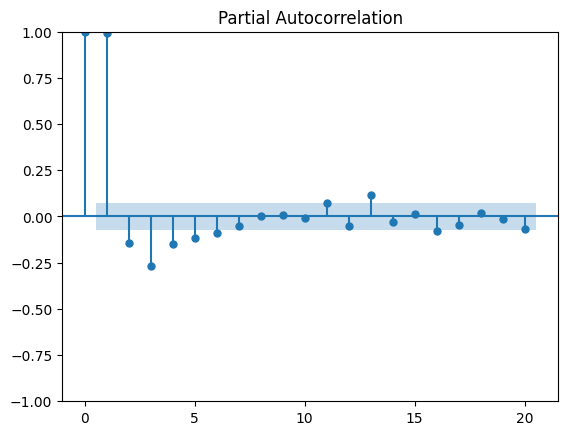

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf

_ = plot_pacf(reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M'), lags=20)

Using this, we can choose lags till 6 months before. lags of 11,13 are false positive.

### 2.5) Reseduals

* What is left is reseduals. It is mostly coming from external factors that are not in the time-series format. For example, external investments in the sale of the company. One way to work on it, is to exclude seasonalities, and trend from a TS and make it stationary (**Excercise**: Search and find out what is stationarity in a TS), then model the rest with other external factors. However, we should keep in mind that external factors affect the trend and seasonality.
For example, assume acompany with increasing trend. external investment such as advertisement has a direct effect on the trend and without them the trend might decrease after a certain period of time. I will discuss this in Lesson 4 (multi-variate TS prediction).

### 2.6) TS decompositio with Statsmodels

So far we learned what are different components of a TS and how to decompose them. In this part and the next part, we use two packages for decomposition.

In [13]:
import sys
import statsmodels as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import seaborn as sns


import sys
sys.path.append('/path/to/directory/')



In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=tunnel.NumVehicles.values, model='additive', period=120)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

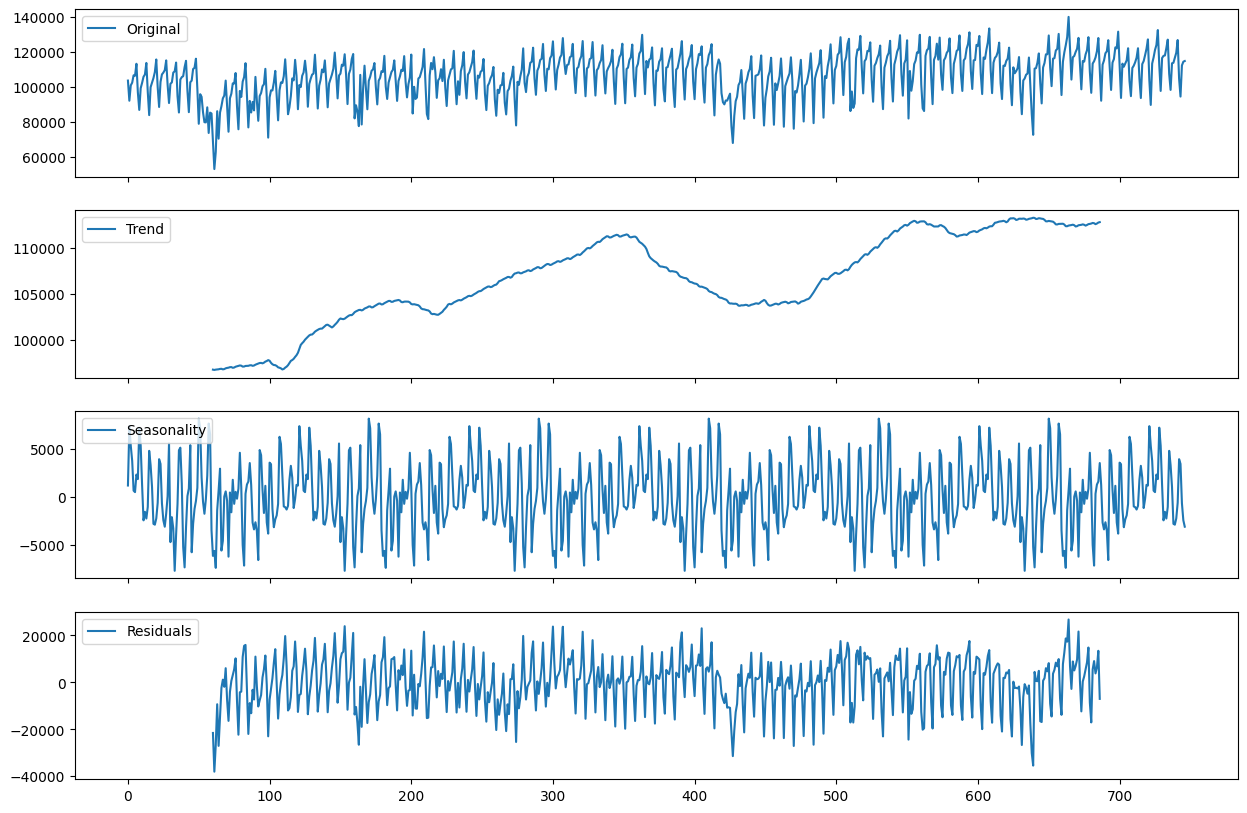

In [15]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(tunnel.NumVehicles.values, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

**Excercise** Work on different options of above method.
* What is 'additive' model? What other choices exist? (multiplicative)
* What is period?
* How can we make the trend smoother?
* Add more questions/curiosity to above.

### 2.7) TS decomposition with Prophet

* Prophet is a package written by facebook group to do the TS decomposition. It is very useful and easy to use. However, it is a kind of black-box.

* This package needs the data to be in certain structure format. More precisely, the input dataframe should have the date columns with name 'ds' and target variable with the name 'y'. 

In [16]:
tunnel.index=tunnel.index.to_timestamp() # the index of tunnel data is of period type, but prophet accepts timestamp format
df_prophet = tunnel.reset_index()
df_prophet = df_prophet.rename(columns={'Day':'ds','NumVehicles':'y'})

* Then we can simply use the fit method to fit the data:

In [17]:
from prophet import Prophet 

model = Prophet()
model.fit(df_prophet)


Importing plotly failed. Interactive plots will not work.


09:04:08 - cmdstanpy - INFO - Chain [1] start processing
09:04:08 - cmdstanpy - INFO - Chain [1] done processing


* A good point about prophet package is that it has been written in the format of sklearn package with fit and predict functions.

* As one of the goals of time-series approaches is to predict the future, prophet has a function to make a dataframe, including future.

In [18]:
future = model.make_future_dataframe(periods = 60)
pred= model.predict(future)

* Now lets look at the predicted dataframe

In [19]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2003-11-01,99338.560320,94100.638581,108133.668286,99338.560320,99338.560320,1721.066520,1721.066520,1721.066520,-4425.845165,-4425.845165,-4425.845165,6146.911684,6146.911684,6146.911684,0.0,0.0,0.0,101059.626840
1,2003-11-02,99359.760139,81365.967532,95626.398866,99359.760139,99359.760139,-11045.924043,-11045.924043,-11045.924043,-17027.742439,-17027.742439,-17027.742439,5981.818396,5981.818396,5981.818396,0.0,0.0,0.0,88313.836096
2,2003-11-03,99380.959958,95921.419175,110502.446380,99380.959958,99380.959958,4176.184043,4176.184043,4176.184043,-1568.218305,-1568.218305,-1568.218305,5744.402347,5744.402347,5744.402347,0.0,0.0,0.0,103557.144001
3,2003-11-04,99402.159777,99251.775985,113198.844159,99402.159777,99402.159777,6511.087996,6511.087996,6511.087996,1071.084719,1071.084719,1071.084719,5440.003277,5440.003277,5440.003277,0.0,0.0,0.0,105913.247773
4,2003-11-05,99423.359596,102176.623068,116700.457481,99423.359596,99423.359596,9799.959538,9799.959538,9799.959538,4723.969934,4723.969934,4723.969934,5075.989603,5075.989603,5075.989603,0.0,0.0,0.0,109223.319133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,2006-01-11,109633.186292,96371.967179,110894.439229,109562.178567,109697.092960,-6221.565385,-6221.565385,-6221.565385,4723.969934,4723.969934,4723.969934,-10945.535319,-10945.535319,-10945.535319,0.0,0.0,0.0,103411.620907
803,2006-01-12,109627.031522,97439.533035,112228.679635,109554.028571,109692.475992,-4718.400220,-4718.400220,-4718.400220,5382.092000,5382.092000,5382.092000,-10100.492220,-10100.492220,-10100.492220,0.0,0.0,0.0,104908.631302
804,2006-01-13,109620.876751,104846.038295,118647.974574,109545.913727,109688.057093,2563.730656,2563.730656,2563.730656,11844.659255,11844.659255,11844.659255,-9280.928598,-9280.928598,-9280.928598,0.0,0.0,0.0,112184.607408
805,2006-01-14,109614.721981,89824.541660,103398.488774,109537.580640,109685.237334,-12928.555346,-12928.555346,-12928.555346,-4425.845165,-4425.845165,-4425.845165,-8502.710181,-8502.710181,-8502.710181,0.0,0.0,0.0,96686.166635


* First of all, this dataframe starts on the same date as the start of original dataset (df_prophet), but it lasts to 60 days more.

* The last column (yhat) is the predicted value for the time-series.

* Then, we have trend, weekly, yearly (two seasonality), additive_terms (residual), and for each of these terms we have lower and upper that shows the confidence interval.

* **Excercise**: What is multiplicative terms and why is it zero?
* **Excercise**: Can we have other seasonality other than weekly and yearly?
* **Excercise**: One of the very interesting useful and important features of prophet package is that it can take the effect of holidays and events into account. How can we include this feature?

#### Plotting

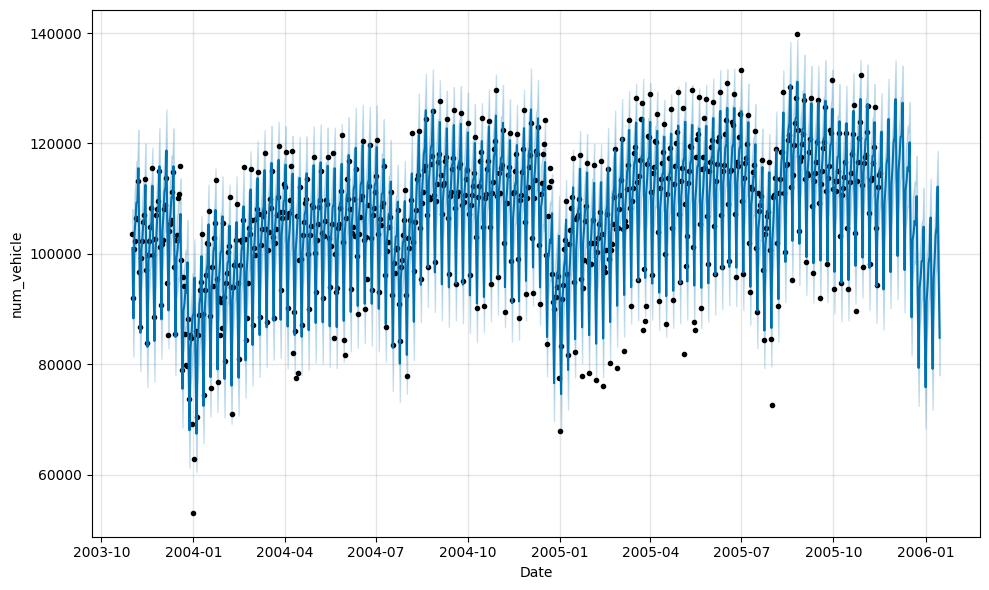

In [20]:
figure = model.plot(pred, xlabel='Date',ylabel='num_vehicle')

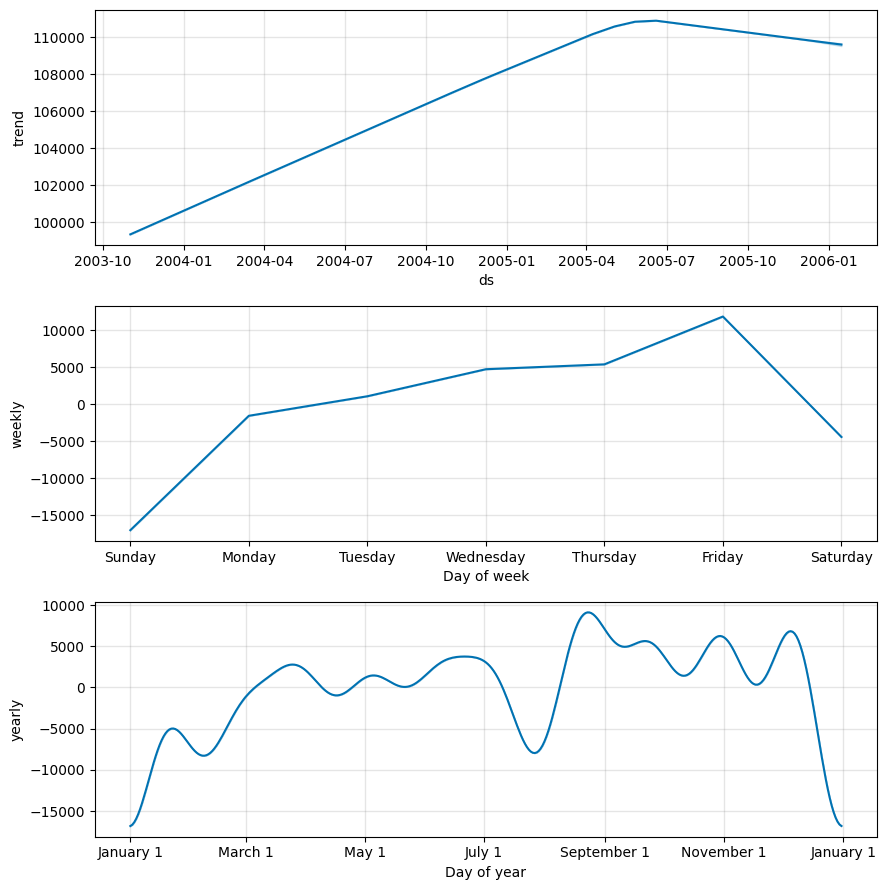

In [21]:
figure2 = model.plot_components(pred)